In [1]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt
import numpy as np

In [2]:
tf.__version__  #'2.7.0'
# tf.config.experimental.list_physical_devices()

'2.7.0'

In [3]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    'PlantVillage',
    shuffle = True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [5]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

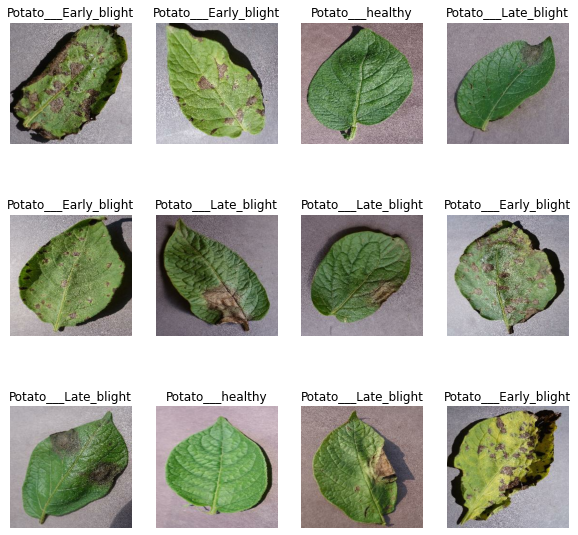

In [6]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
#     print(image_batch.shape)   ## (32, 256, 256, 3)
#     print(label_batch.numpy())
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])
        plt.axis('off')

In [7]:
len(dataset)

68

In [8]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    
    ds_size = len(ds)
    
    if shuffle == True:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split*ds_size)
    val_size = int(val_split*ds_size)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds,val_ds,test_ds

In [9]:
train_ds,val_ds,test_ds = get_dataset_partitions_tf(dataset)
print(len(train_ds), len(val_ds), len(test_ds))

54 6 8


In [10]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [11]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [12]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)  
])

In [13]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])

model.build(input_shape=input_shape)

In [14]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [15]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [16]:
%%time

#for cpu Wall time: 9min 48s
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/50
54/54 [==============================] - 35s 314ms/step - loss: 0.9022 - accuracy: 0.5220 - val_loss: 0.9849 - val_accuracy: 0.4115
Epoch 2/50
54/54 [==============================] - 6s 118ms/step - loss: 0.7445 - accuracy: 0.6325 - val_loss: 0.5300 - val_accuracy: 0.7812
Epoch 3/50
54/54 [==============================] - 6s 114ms/step - loss: 0.4755 - accuracy: 0.8073 - val_loss: 0.2502 - val_accuracy: 0.9010
Epoch 4/50
54/54 [==============================] - 6s 114ms/step - loss: 0.2508 - accuracy: 0.9039 - val_loss: 0.7291 - val_accuracy: 0.6198
Epoch 5/50
54/54 [==============================] - 6s 113ms/step - loss: 0.2064 - accuracy: 0.9236 - val_loss: 0.4092 - val_accuracy: 0.8594
Epoch 6/50
54/54 [==============================] - 6s 112ms/step - loss: 0.1938 - accuracy: 0.9317 - val_loss: 0.8332 - val_accuracy: 0.5990
Epoch 7/50
54/54 [==============================] - 6s 113ms/step - loss: 0.3240 - accuracy: 0.8727 - val_loss: 0.2763 - val_accuracy: 0.9062
Epoch

In [17]:
scores = model.evaluate(test_ds)
scores

8/8 [==============================] - 11s 35ms/step - loss: 0.0623 - accuracy: 0.9844


[0.062342479825019836, 0.984375]

In [18]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [19]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [20]:
history.history['accuracy']

[0.5219907164573669,
 0.6325231194496155,
 0.8072916865348816,
 0.9039351940155029,
 0.9236111044883728,
 0.9317129850387573,
 0.8726851940155029,
 0.9652777910232544,
 0.9565972089767456,
 0.9658564925193787,
 0.9635416865348816,
 0.9745370149612427,
 0.9774305820465088,
 0.9733796119689941,
 0.9699074029922485,
 0.9803240895271301,
 0.984375,
 0.9739583134651184,
 0.9855324029922485,
 0.9826388955116272,
 0.9635416865348816,
 0.9739583134651184,
 0.9722222089767456,
 0.984375,
 0.9756944179534912,
 0.984375,
 0.9728009104728699,
 0.9872685074806213,
 0.9866898059844971,
 0.9884259104728699,
 0.9681712985038757,
 0.9739583134651184,
 0.9837962985038757,
 0.9878472089767456,
 0.9947916865348816,
 0.984375,
 0.9890046119689941,
 0.9855324029922485,
 0.9814814925193787,
 0.9872685074806213,
 0.9623842835426331,
 0.9797453880310059,
 0.9901620149612427,
 0.9953703880310059,
 0.9936342835426331,
 0.9913194179534912,
 0.9866898059844971,
 0.9947916865348816,
 0.9959490895271301,
 0.99479168

In [21]:
acc = history.history['accuracy']
loss = history.history['loss']

val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Loss')

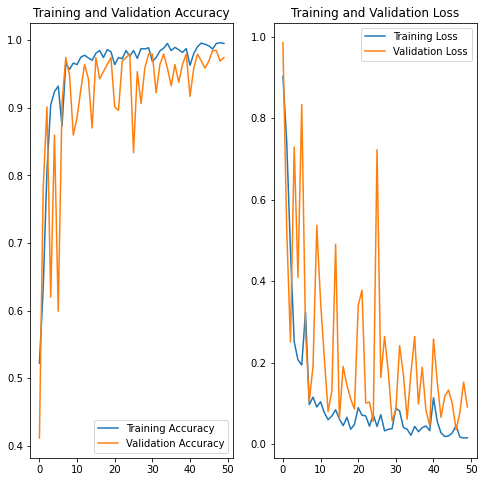

In [22]:
plt.figure(figsize=(8,8))

plt.subplot(1,2,1)
plt.plot(range(EPOCHS),acc, label='Training Accuracy')
plt.plot(range(EPOCHS),val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS),loss, label='Training Loss')
plt.plot(range(EPOCHS),val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

first image to predict
actual label :  Potato___Early_blight
predicted label :  Potato___Early_blight


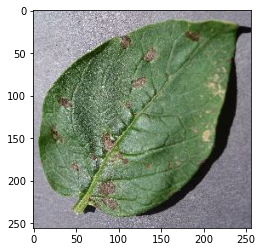

In [23]:
for images_batch, labels_batch in test_ds.take(1):
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print('first image to predict')
    plt.imshow(first_image)
    print('actual label : ', class_names[first_label])
    
    batch_predictions = model.predict(images_batch)
    print('predicted label : ', class_names[np.argmax(batch_predictions[0])])
    

In [24]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) #Create a batch
    
    predictions = model.predict(img_array)
    
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100*(np.max(predictions[0])), 2)
    return predicted_class, confidence

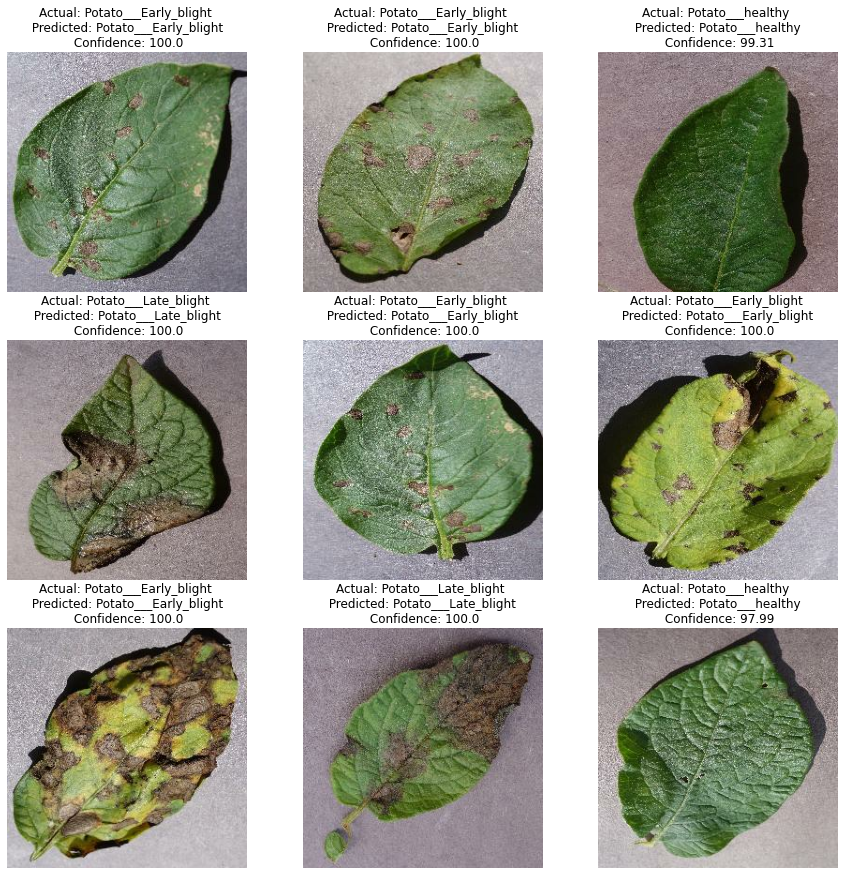

In [25]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        
        plt.title(f"Actual: {actual_class} \n Predicted: {predicted_class} \n Confidence: {confidence}")
        
        plt.axis('off')

In [27]:
# import os
# model_version =max([int(i) for i in os.listdir('../saved_models')+[0]])+1 
# model.save(f'../saved_models/{model_version}')

In [5]:
MODEL = tf.keras.models.load_model("../saved_models/1")
MODEL

In [26]:
model.save("../potatoes.h5")